# Modelling

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    f1_score
)
from xgboost import XGBClassifier

import sys,os
notebook_path = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.append(project_root)

from utils.ml_tools import train_model, model_evaluation

In [2]:
np.random.seed(42)

## Import data

In [3]:
data = pd.read_csv('../data/cleaned_engineered_data.csv')

In [4]:
X = data.drop(columns=['Churn'])
y = data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Baseline

This analysis implements a contract-based heuristic baseline for churn prediction, leveraging the relationship between customer contract duration and churn behavior. The approach uses data-driven thresholds rather than simple rule-based predictions

In [5]:
import plotly.express as px
contract_churn_rates = {}
for contract_type in ['Month-to-month', 'One year', 'Two year']:
    if f'Contract_{contract_type}' in X_train.columns:
        mask = X_train[f'Contract_{contract_type}'] == 1
        churn_rate = y_train[mask].mean()
        contract_churn_rates[contract_type] = churn_rate
        print(f"{contract_type} churn rate: {churn_rate:.3f}")

# Use the churn rates to set thresholds
# Predict churn if customer has contract type with churn rate > threshold
thresholds = np.linspace(0, 1, 100)
f1_scores = []

for t in thresholds:
    preds = np.zeros(len(X_test))
    
    for contract_type, churn_rate in contract_churn_rates.items():
        if churn_rate > t and f'Contract_{contract_type}' in X_test.columns:
            mask = X_test[f'Contract_{contract_type}'] == 1
            preds[mask] = 1
    
    f1 = f1_score(y_test, preds)
    f1_scores.append(f1)

fig = px.line(
    x=thresholds,
    y=f1_scores,
    labels={"x": "Churn Rate Threshold", "y": "F1 Score"},
    title="Contract-based Heuristic Baseline: Threshold vs F1 Score"
)
fig.show()

print(f"Best Contract F1 Score: {max(f1_scores):.3f}")

Month-to-month churn rate: 0.427
One year churn rate: 0.111
Two year churn rate: 0.029


Best Contract F1 Score: 0.574


Baseline Achievement:
- Best F1 Score: 0.574
- Optimal Threshold: 0.424

Implications:
- This suggests Contract type has significant predictive power for churn
- The optimal threshold lower than standard (0.5) indicates that churn class is less frequent than non-churn

## Model training

In [6]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

In [7]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [8]:
results = {}

for name, model in models.items():
    
    results[name] = train_model(name, model, X_train, y_train)

# Select best model based on ROC AUC (you can change this criterion)
best_model_name = max(results.keys(), key=lambda x: results[x]['cv_roc_auc'])
best_model = results[best_model_name]['model']
best_scores = results[best_model_name]

print(f"Selected: {best_model_name}")
print(f'ROC AUC (avg 5-fold): {best_scores["cv_roc_auc"]:.4f}')
print(f'F1 Score (avg 5-fold): {best_scores["cv_f1"]:.4f}')

Logistic Regression:
  ROC AUC: 0.8488 ± 0.0142
  F1:      0.5922 ± 0.0263
  Precision: 0.6657
  Recall:    0.5338

Random Forest:
  ROC AUC: 0.8081 ± 0.0121
  F1:      0.5419 ± 0.0111
  Precision: 0.5992
  Recall:    0.4950



/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[12:27:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[12:27:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[12:27:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




XGBoost:
  ROC AUC: 0.8161 ± 0.0122
  F1:      0.5513 ± 0.0212
  Precision: 0.5937
  Recall:    0.5151

Selected: Logistic Regression
ROC AUC (avg 5-fold): 0.8488
F1 Score (avg 5-fold): 0.5922


/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[12:27:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[12:27:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




Observations
- Logistic Regression is the selcted model, achieving ROC AUC score of 0.8479, and F1 score of 0.5846

Insights
- The F1 score is only slightly better than  heuristic baseline of 0.574, which suggests there's room for improvement in precision/recall balance
- The gap between your ROC AUC (0.8479) and F1 score (0.5846) indicates that:
    - The model is good at ranking predictions (ROC AUC) But there might be issues with the **classification threshold** or **class imbalance**

## Hyperparameter tuning

### Logistic regression

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],  
    'class_weight': [None, 'balanced']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {'f1': make_scorer(f1_score), 'roc_auc': 'roc_auc'}

# Perform grid search
grid_search = GridSearchCV(results['Logistic Regression']['model'], param_grid, cv=cv, scoring=scoring, refit='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score from CV:", grid_search.best_score_)

lr_model = grid_search.best_estimator_

Best Parameters: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
Best F1 Score from CV: 0.6379154906361695


In [10]:
model_evaluation(lr_model, X_train, y_train, X_test, y_test)

=== PHASE 1: COMPREHENSIVE MODEL EVALUATION ===
1. 📊 TRAINING vs TEST PERFORMANCE
Training F1:    0.6402
Test F1:        0.6234
F1 Difference:  0.0168 ✅

Training ROC:   0.8512
Test ROC:       0.8453
ROC Difference: 0.0059

2. 🎯 BASELINE COMPARISON
Baseline F1:        0.5740
Your Model F1:      0.6234
Improvement:        +0.0494 (+8.6%)

3. 📋 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    No Churn       0.90      0.74      0.81      1035
       Churn       0.52      0.78      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409


4. 🔍 CONFUSION MATRIX ANALYSIS
True Negatives (Correct No-Churn):  762
False Positives (Wrong Churn):      273
False Negatives (Missed Churn):     81
True Positives (Correct Churn):     293

Churn Capture Rate: 78.3% (How many churners did we catch?)
Precision Rate:     51.8% (How accurate are o

{'test_f1': 0.6234042553191489,
 'test_roc_auc': 0.845327959905965,
 'train_f1': 0.640235735333512,
 'train_roc_auc': 0.8512187278041243,
 'confusion_matrix': array([[762, 273],
        [ 81, 293]]),
 'y_test_proba': array([0.17969532, 0.82050482, 0.18807665, ..., 0.3044589 , 0.05966446,
        0.06712859])}

In [ ]:
#Get probabilities from your best model
y_prob = lr_model.predict_proba(X_test)[:, 1]

# Find optimal threshold for F1
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
f1_scores = f1_scores[:-1]  # Remove last element to match thresholds length

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
max_f1 = f1_scores[optimal_idx]

print(f"Current F1 with default threshold (0.5): {f1_score(y_test, best_model.predict(X_test)):.4f}")
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"Max possible F1 with threshold tuning: {max_f1:.4f}")
print(f"Potential F1 improvement: +{max_f1 - 0.5846:.4f}")

y_pred_final = (y_prob >= optimal_threshold).astype(int)

print(classification_report(y_test, y_pred_final))
print(confusion_matrix(y_test, y_pred_final))

Current F1 with default threshold (0.5): 0.6234
Optimal threshold: 0.5522
Max possible F1 with threshold tuning: 0.6322
Potential F1 improvement: +0.0476
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1035
           1       0.55      0.74      0.63       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409

[[814 221]
 [ 99 275]]


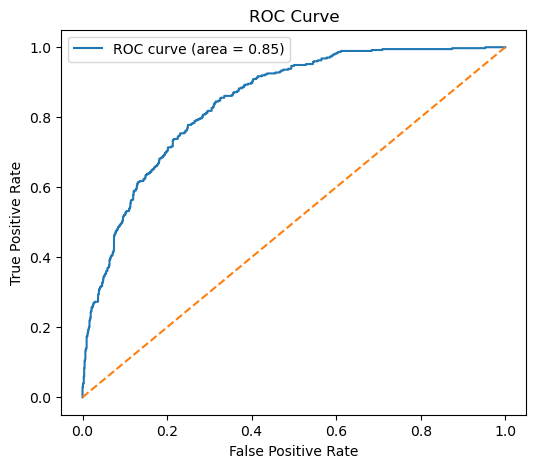

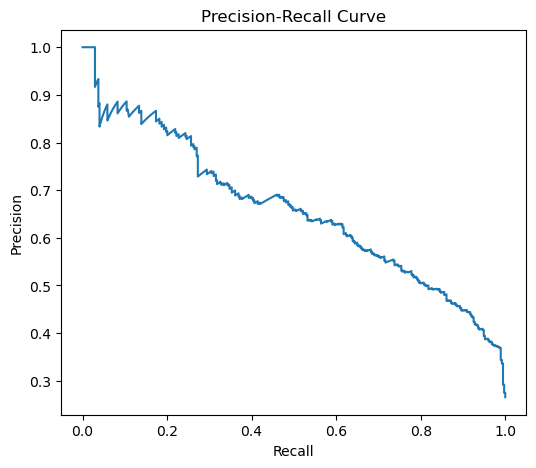

In [126]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve')
plt.legend(); plt.show()

# Precision-Recall Curve
precisions, recalls, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(recalls, precisions)
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve')
plt.show()


In [127]:
best_model.fit(X_test, y_test)
y_pred = best_model.predict(X_test)
test_roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
test_f1 = f1_score(y_test, y_pred)
print(f"Test ROC AUC: {test_roc_auc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

Test ROC AUC: 0.8473
Test F1 Score: 0.6349


In [128]:
y_probs = best_model.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_test, y_probs >= t) for t in thresholds]

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)
print(f"Best Threshold: {best_threshold:.4f}, Max F1: {best_f1:.4f}")

Best Threshold: 0.5800, Max F1: 0.6396


In [129]:
y_pred_best = (y_probs >= best_threshold).astype(int)
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best, digits=4))

[[856 179]
 [114 260]]
              precision    recall  f1-score   support

           0     0.8825    0.8271    0.8539      1035
           1     0.5923    0.6952    0.6396       374

    accuracy                         0.7921      1409
   macro avg     0.7374    0.7611    0.7467      1409
weighted avg     0.8054    0.7921    0.7970      1409



In [130]:
feature_importance = pd.Series(best_model.coef_[0], index=X_test.columns).sort_values(ascending=False)
print(feature_importance.head(10))

ChargePerMonthRatio            0.542266
Contract_Month-to-month        0.323465
Fiber_NoTechSupport            0.263600
M2M_ElectronicCheck            0.204925
InternetService_Fiber optic    0.203436
Senior_Contract                0.197512
PaperlessBilling               0.154690
tenure_group_0–6               0.141012
new_customer                   0.141012
FiberOptic_StreamingTV         0.110137
dtype: float64
